## Подгружаем библиотеки

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import requests
from urllib.parse import urlencode

import pandahouse as ph

# Решаем задачу 1

## Подгружаем данные

### Пишем функцию для загрузки файлов с Яндекс.Диска

In [3]:
def get_data_yadisk(yadisk_url, file_storage_path):
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = yadisk_url  # Сюда вписываете вашу ссылку

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    dist_path = file_storage_path
    with open(dist_path, 'wb') as f:   # Здесь укажите нужный путь к файлу
        f.write(download_response.content)
    

### Скачиваем данные

In [4]:
# Прописываем URL для скачивания файлов
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
url_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
url_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'

# Прописываем названия для файлов
file_path_groups = 'groups_final_test.csv'
file_path_groups_add = 'groups_add_final_test.csv'
file_path_checks = 'checks_final_test.csv'
file_path_active_studs = 'active_studs_final_test.csv'

In [5]:
# Скачиваем таблицу 'groups'
# Это файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа) 

get_data_yadisk(url_groups,file_path_groups)

# Записываем таблицу 'groups' в DataFrame
groups = pd.read_csv(file_path_groups, sep = ';')

# Проверяем, что DataFrame создалася корректно
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
# Скачиваем таблицу 'groups_add'
get_data_yadisk(url_groups_add,file_path_groups_add)

# Записываем таблицу 'groups' в DataFrame
groups_add = pd.read_csv(file_path_groups_add, sep = ',')

# Проверяем, что DataFrame создалася корректно
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [7]:
# Скачиваем таблицу 'checks'
get_data_yadisk(url_checks,file_path_checks)

# Записываем таблицу 'checks' в DataFrame
checks = pd.read_csv(file_path_checks, sep = ';')

# Проверяем, что DataFrame создалася корректно
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [8]:
# Скачиваем таблицу 'active_studs'
get_data_yadisk(url_active_studs,file_path_active_studs)

# Записываем таблицу 'active_studs' в DataFrame
active_studs = pd.read_csv(file_path_active_studs, sep = ';')

# Проверяем, что DataFrame создалася корректно
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


В таблицах 'checks' и 'active_studs' колонки со студентами называются 'student_id', а в других таблицах -- просто 'id'
Это не очень удобно. Поменяем колонки в этих таблицах на просто 'id'

In [9]:
# Меняем название колонок 'student_id' на 'id'

active_studs = active_studs.rename(columns = {'student_id':'id'})
checks = checks.rename(columns = {'student_id':'id'})

## Проводим EDA

#### Изучаем таблицу 'groups'

In [10]:
# Смотрим структуру таблицы

groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [11]:
# Смотрим размеры таблицы

groups.shape

(74484, 2)

In [12]:
# Проверяем, наличие дубликатов id студентов

groups.duplicated(subset = ['id']).sum()

np.int64(0)

Дубликатов нет. В таблице только уникальные id студентов

In [13]:
# Смотрим соотношения тестовой и контрольной групп

groups['grp'].value_counts(normalize = True)

grp
B    0.803032
A    0.196968
Name: proportion, dtype: float64

~80% пользователей -- в тестовой группе

#### Изучаем таблицу 'groups_add'

In [14]:
# Изучаем структуру таблицы

groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [15]:
# Изучаем размеры таблицы
groups_add.shape[0]

92

В таблице 'groups_add' всего 92 наблюдения по сравнению с ~74 000 в 'groups' 

In [16]:
# Проверяем, наличие дубликатов id студентов

groups_add.duplicated(subset = ['id']).sum()

np.int64(0)

Дубликатов нет. В таблице только уникальные id студентов

In [17]:
# Смотрим соотношения тестовой и контрольной групп

groups_add['grp'].value_counts(normalize = True)

grp
B    0.76087
A    0.23913
Name: proportion, dtype: float64

Соотношение групп схоже с таблицей 'groups'

#### Изучаем таблицу 'active_studs'

In [18]:
# Смотрим структуру таблицы

active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [19]:
# Смотрим размеры таблицы

active_studs.shape

(8341, 1)

In [20]:
# Проверяем, наличие дубликатов id студентов

active_studs.duplicated().sum()

np.int64(0)

Дубликатов нет. В таблице только уникальные id студентов

#### Изучаем таблицу 'checks'

In [21]:
# Смотрим структуру таблицы

checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [22]:
# Смотрим размеры таблицы

checks.shape

(541, 2)

In [23]:
# Проверяем, наличие дубликатов id студентов

checks.duplicated(subset = ['id']).sum()

np.int64(0)

В таблице нет дубликатов. На одного студента приходится одно значение 'rev'.

У нас нет информации по конкретным покупкам, так что будем считать, 
что 'rev' -- это суммарная revenue (прибыль) с пользователя за период проведения эксперимента.

### Дополнительно изучаем структуру данных

##### Есть несколько вопросов по имеющимся таблицам:
1. Как соотносятся между собой таблицы 'groups' и 'groups_add'. Пересекаются ли они?
2. Могут ли быть пользователи, которые купили услуги и попали в таблицу 'checks', но при этом не были активными во время эксперимента и не попали в таблицу 'active_studs'
3. Есть ли пользователи в 'active_studs', которых нет в 'groups'?
4. Есть ли пользователи в 'checks', которых нет в 'groups'?


#### Изучаем, как соотносятся между собой таблицы 'groups' и 'groups_add'

In [24]:
# Смотрим кол-во строк в обоих таблицах

print(groups.shape[0])
print(groups_add.shape[0])

74484
92


В таблице 'groups_add' всего 92 юзера по сравнению с 74484 в таблице 'groups'

Смотрим, пересекаются ли id студентов в таблицах

In [25]:
# Смотрим, сколько id студентов из 'groups' есть в 'groups_add'

groups[groups['id'].isin(groups_add['id'])].shape[0]

0

ID студентов не пересекаются в двух таблицах

Изучаем соотношение групп в таблицах

In [26]:
# Смотрим соотношение групп в 'groups'

groups['grp'].value_counts(normalize = True)

grp
B    0.803032
A    0.196968
Name: proportion, dtype: float64

In [27]:
groups_add['grp'].value_counts(normalize = True)

grp
B    0.76087
A    0.23913
Name: proportion, dtype: float64

Соотношение групп примерно примерно равное

##### Вывод по таблицам 'groups' и 'groups_add': 

Таблицы 'groups' и 'groups_add' похожи по структуре и соотношению групп. 

Данные из 'groups_add' лучше не использовать в анализе. Их прислали спустя два дня после главной таблицы 'groups'. Данные могли быть получены после истечения срока эксперимента, а значит могли быть подвержены влиянию не только экспериментальных факторов.

Мы не можем узнать, при каких условиях собраны эти данные, и почему их прислали только спустя два дня, поэтому лучше будет исключить их из анализа. Тем более, что в таблице 'groups_add' всего 92 наблюдения по сравнению с 74484 в 'groups'. Такая прибавка в наблюдениях очень слабо повлияет на мощность теста при и так большой выборке.

#### Изучаем, есть ли пользователи, которые в течение эксперимента купили услуги, но не были активными  

In [28]:
# Смотрим, какие id есть в 'checks', но нет в 'active_studs', и сколько их

# Делаем таблицу с нужными id
inactive_buying_studs = checks[~checks['id'].isin(active_studs['id'])]

# Смотрим, сколько в ней id
print(inactive_buying_studs.shape[0])

# Смотрим, какая доля таких id в общей массе платящих пользователей
print(inactive_buying_studs.shape[0] / checks.shape[0] * 100) 

149
27.54158964879852


##### Вывод по неактивным платящим пользователям:
Такие пользователи есть, и их почти треть от общего числа платящих пользователей. Такой большой процент вряд ли может быть ошибкой в данных.

При анализе будем учитывать, что пользователь может совершать покупки, не заходя на платформу.

#### Проверяем, есть в 'active_studs' пользователи, которых нет в 'groups' и в 'groups_add'

In [29]:
# Объединяем таблицы 'groups' и 'groups_add'

groups_all = pd.concat([groups, groups_add])

In [30]:
# Выделяем id, которые есть в 'active_studs', но нет в 'groups' и 'groups_add'

active_not_in_groups_all = active_studs[~active_studs['id'].isin(groups_all['id'])]

# Считаем кол-во таких id

active_not_in_groups_all.shape[0]

0

**Вывод**: все id из 'active_studs' есть в 'groups' или 'groups_add'

#### Проверяем, есть ли в 'checks' id, которые нет в 'groups' или 'groups_add'

In [31]:
# Выделяем id, которые есть в 'checks', но нет в 'groups' и 'groups_add'

paying_not_in_groups_all = checks[~checks['id'].isin(groups_all['id'])]

# Считаем кол-во таких id

paying_not_in_groups_all.shape[0]

0

**Вывод**: все id из 'checks' есть в 'groups' или 'groups_add'

## Продумываем метрики
Нужно продумать и записать метрики, по которым мы будем оценивать качество механики оплаты. Дальше из них нужно будет выбрать наиболее подходящие.

#### - Процент платящих пользователей - Paying Share
**Как рассчитывается**
(кол-во платящих пользователей) / (кол-во активных пользователей)

Процент платящих пользователей хорошо подходит для оценки механики оплаты. На Paying Share влияет не так много факторов, и механика оплаты -- один из основных. Но Paying Share не оценивает денежную составляющую.


#### - Средняя прибыль на пользователя - ARPU
**Как рассчитывается:**  
(прибыль за период) / (кол-во всех пользователей за период)

Довольно стандартная метрика, которая в том числе хорошо подойдет и для оценки механики оплаты. Однако, как и большинство "денежных" метрик может иметь экстремально ненормальное распределение.


#### - Средняя прибыль на платящего пользователя - ARPPU
**Как рассчитывется:**
(прибыль за период) / (кол-во платящих пользователей)

Также подходящая метрика. Можно использовать как вспомогательную вместе с ARPU.

## Выбираем метрики

Из указанных выше метрик нам для анализа подойдут ARPU и ARPPU.

Их основные преимущества:
1. Привычные метрики для бизнеса
2. Легко интерпретировать

Основные недостатки:
1. Как и многие "денежные" метрики, могут иметь ненормальное распределение, что ограничивает применение стат тестов

Решение о внедрении новой системы оплаты мы будем принимать по ARPU. В данном случае ARPU - более релевантная метрика для оценки системы оплаты, т.к. она учитывает всех пользователей -- платящих и не платящих. ARPPU будем использовать как вспомогательную.

## Подготавливаем данные

### Удаляем из таблиц наблюдения по юзерам из 'groups_add'
Так как мы не будем использовать при анализе пользователей из таблицы 'groups_add', нужно будет удалить наблюдения по этим пользователям из таблиц 'active_studs' и 'checks'.

**Удаляем данные из таблицы 'active_studs'**

In [32]:
# Создаем копию таблицы 'active_studs' без id из 'groups_add'

active_studs_filtered = (active_studs[~active_studs['id']
                        .isin(groups_add['id'])] 
                        .copy()) # создаем копию, чтобы избежать конфликтов в дальнейшем 

In [33]:
# Проверяем, что таблица отфильтровалась корректно

active_studs_filtered[active_studs_filtered['id'].isin(groups_add['id'])]

,id


Таблица отфильтровалась корректно

**Удаляем данные из таблицы 'checks'**

In [34]:
# Создаем копию таблицы 'checks' без id из 'groups_add'

checks_filtered = (checks[~checks['id']
                  .isin(groups_add['id'])]
                  .copy()) # создаем копию, чтобы избежать конфликтов в дальнешем 

In [35]:
# Проверяем, что таблица отфильтровалась корректно

checks_filtered[checks_filtered['id'].isin(groups_add['id'])]

,id,rev


Таблица отфильтровалась корректно

## Рассчитываем метрики
Сейчас нам нужно собрать данные по каждой метрике в двух форматах:
1. Усредненные данные по всем пользователям, то есть сами метрики. По ним посмотрим, есть ли вообще различие между группами
2. Неагрегированные данные по каждому пользователю. Эти данные будем использовать при рассчетах тестов

### Рассчитываем среднюю прибыль на пользователя - ARPU

In [36]:
# Джоиним прибыль с пользователя из 'checks_filtered' в 'groups' и выделяем в отдельную таблицу

groups_w_rev = (groups
                .merge(right = checks_filtered, on = 'id', how = 'left') # джоиним таблицу checks
                .fillna(value = 0) # пропуски заполняем нулями
               )

groups_w_rev.head()

,id,grp,rev
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


In [37]:
# Проверяем, что в результате джоина не добавилось ничего лишнего
# Результаты всех функций ниже должны быть равны

print(groups['id'].count())          # кол-во id в изначальной таблице groups
print(groups_w_rev['id'].count())    # кол-во id в получившейся таблице после джоина
print(groups['id'].nunique())        # кол-во уникальных id в изначальной таблице groups
print(groups_w_rev['id'].nunique())  # кол-во уникальных id в получившейся таблице после джоина

74484
74484
74484
74484


Таблички сджоинились корректно

In [38]:
# Разбиваем получившуюся таблицу c RPU на две по группам A и B

a_group_rpu = groups_w_rev.query('grp == "A"')
b_group_rpu = groups_w_rev.query('grp == "B"')

In [39]:
# Вычисляем средний доход на пользователя (ARPU) по каждой группе

a_group_arpu = a_group_rpu['rev'].mean()
b_group_arpu = b_group_rpu['rev'].mean()

### Рассчитываем прибыль на платящего пользователя - ARPPU

In [40]:
# Джоиним информацию по группам пользователей из таблицы 'groups' в 'checks_filtered' и выделяем в отдельную таблицу

paying_groups_w_rev = checks_filtered.merge(right = groups, on = 'id', how = 'left')

In [41]:
# Проверяем, что в результате джоина не добавилось ничего лишнего
# Результаты всех функций ниже должны быть одинаковыми

print(checks_filtered['id'].count())       # кол-во id в таблице checks_filtered, куда мы джоинили группы
print(checks_filtered['id'].nunique())     # кол-во уникальных id в таблице checks_filtered, куда мы джоинили группы
print(paying_groups_w_rev['id'].count())   # кол-во id в получившейся таблице после джоина
print(paying_groups_w_rev['id'].nunique()) # кол-во уникальных id в получившейся таблице после джоина


540
540
540
540


Таблицы сджоинились корректно

In [42]:
# Разбиваем получившуюся таблицу с RPPU на две по группам A и B

a_group_rppu = paying_groups_w_rev.query('grp == "A"')
b_group_rppu = paying_groups_w_rev.query('grp == "B"')

In [43]:
# Вычисляем средний доход на платящего пользователя (ARPPU) по каждой группе

a_group_arppu = a_group_rppu['rev'].mean()
b_group_arppu = b_group_rppu['rev'].mean()

## Изучаем различия между группами
Для начала нужно посмотреть, есть ли вообще различия в метриках между группами. Если есть, то проверим их статистическую значимость с помощью тестов

### Сравниваем ARPU

In [44]:
# Выводим ARPU в каждой группе и сравниваем "на глаз"

print(f'ARPU в группе A = {a_group_arpu}')
print(f'ARPU в группе B = {b_group_arpu}')


ARPU в группе A = 6.277418035580396
ARPU в группе B = 8.013809767107485


Как видим, разница в ARPU есть. Нужно будет проверить статистическую значимость различий.

### Сравниваем ARPPU

In [45]:
# Выводим ARPU в каждой группе и сравниваем "на глаз"

print(f'ARPPU в группе A = {a_group_arppu}')
print(f'ARPPU в группе B = {b_group_arppu}')

ARPPU в группе A = 860.7102803738318
ARPPU в группе B = 1106.9976988452656


ARPPU в группах также различается

## Подбираем статистические тесты
Теперь нужно подобрать статистические критерии, с помощью которых будем сравнивать метрики в двух группах и оценивать статистическую значимость различий, если такие будут.

**Выбор статистических тестов будет зависеть от следующих факторов:**
1. Типы переменных
2. Соблюдение требований для статистических тестов 

### Выбираем Стат критерий для ARPU
ARPU -- количественная непрервыная переменная. Для нее подойдут:
- Т-тест, если соблюдаются допущения: нормальное распределение, отсутствие выбросов, гомогенность дисперсий и независимость наблюдений. <br>
Эти требования не строго обязательны, если выборки достаточно большие. У нас в обоих группах суммарно около 70 тысяч наблюдений, что достаточно много. Но если распределения экстремально перекошены, даже при таких объямах данных Т-тест вряд ли подойдет. 
- Бутстрап, если распределение данные крайне сильно смещено или имеются ярко выраженные выбросы

Теперь изучим данные, чтобы понять, какой из двух вариантов выбрать.

#### Независимость наблюдений
Это допущение соблюдается, потому наблюдения в нашем случае -- это отдельные пользователи, доход с которых не зависит друг от друга. 

#### Изучаем распределение RPU

Text(-12.430555555555555, 0.5, 'Кол-во пользователей')

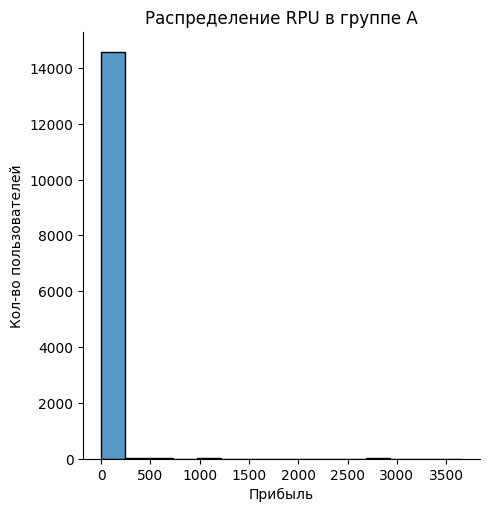

In [46]:
# Изучаем распределение RPU в группе A

sns.displot(data = a_group_rpu, x = 'rev')
plt.title("Распределение RPU в группе А")
plt.xlabel('Прибыль')
plt.ylabel('Кол-во пользователей')

In [47]:
# Смотрим кол-во наблюдений в группе A

a_group_rpu.shape[0]

14671

Text(-12.430555555555555, 0.5, 'Кол-во пользователей')

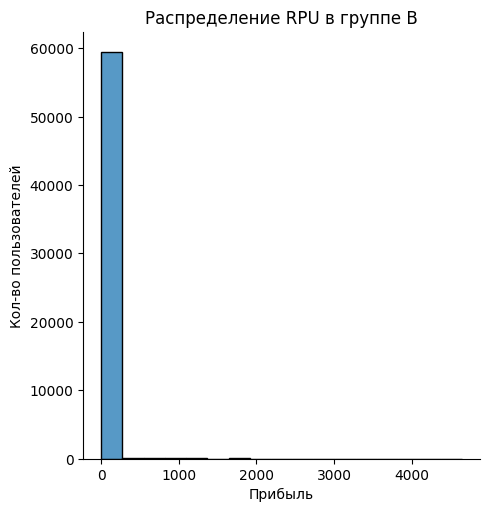

In [48]:
# Изучаем распределение RPU в группе B

sns.displot(data = b_group_rpu, x = 'rev')
plt.title("Распределение RPU в группе B")
plt.xlabel('Прибыль')
plt.ylabel('Кол-во пользователей')

In [49]:
# Смотрим кол-во наблюдений в группе B

b_group_rpu.shape[0]

59813

Распределение RPU в обеих группах явно выглядит ненормальным и экстремально асимметричным. <br>
Также сразу визуально видны выбросы в обеих группах.

#### Проверяем распределение RPU на нормальность

In [50]:
# Проверяем распределение в группе A
st.normaltest(a_group_rpu['rev'])

NormaltestResult(statistic=np.float64(34659.751000095835), pvalue=np.float64(0.0))

In [51]:
# Проверяем распределение в группе B
st.normaltest(a_group_rpu['rev'])

NormaltestResult(statistic=np.float64(34659.751000095835), pvalue=np.float64(0.0))

Ожиданиемо, тест подтверждает: данные распределены ненормально

#### Проверяем равенство дисперсий

In [52]:
# Проверяем равенство дисперсий с помощью теста Левена
levene_res_arpu = st.levene(a_group_rpu['rev'], b_group_rpu['rev'])

print(levene_res_arpu)

LeveneResult(statistic=np.float64(2.895615700927649), pvalue=np.float64(0.0888250079218959))


p-value по тесту Левена > 0.05 <br>
Нулевая гипотеза о равенстве дисперсий сохраняется

**Вывод по стат критерию для ARPU:** <br>
Т-тест в данном случае не подойдет. Несмотря на очень большой объем выборки (тысячи и десятки тысяч наблюдений), распределение слишком асимметрично и перекошено. Логарифмирование, возможно, поможет исправить распределение, но добавит сложности в интерпретации метрики. <br>

Для определения статистической значимости различий ARPU лучше будет применять Бутстрап с 95% ДИ.<br>

### Выбираем стат критерий для ARPPU
Как и для ARPU, здесь у нас две опции -- Т-тест и Бутстрап. <br>
Чтобы отпределиться между ними, проверим соблюдения все тех же требований для применения Т-теста.

#### Изучаем распределение RPPU

Text(13.819444444444445, 0.5, 'Кол-во платящих пользователей')

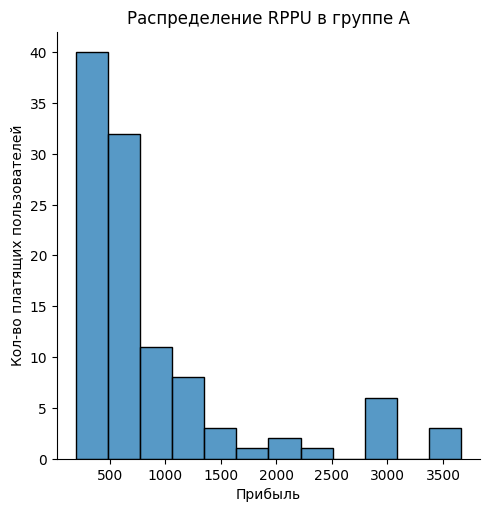

In [53]:
# Изучаем распределение RPPU в группе A

sns.displot(data = a_group_rppu, x = 'rev')
plt.title("Распределение RPPU в группе A")
plt.xlabel('Прибыль')
plt.ylabel('Кол-во платящих пользователей')

In [54]:
# Смотрим кол-во наблюдение в группе A

a_group_rppu.shape[0]

107

Text(5.069444444444445, 0.5, 'Кол-во платящих пользователей')

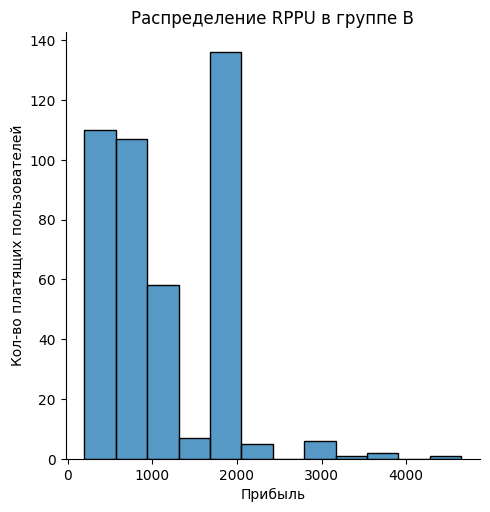

In [55]:
# Изучаем распределение RPPU в группе B

sns.displot(data = b_group_rppu, x = 'rev')
plt.title("Распределение RPPU в группе B")
plt.xlabel('Прибыль')
plt.ylabel('Кол-во платящих пользователей')

In [56]:
# Смотрим кол-во наблюдений в группе B

b_group_rppu.shape[0]

433

Распределение RPPU выглядит лучше, чем RPU, но все еще не выглядит нормальным. <br>
Проверим нормальность распределений дополнительно с помощью теста.

In [57]:
# Проверяем распределение в группе A
st.normaltest(a_group_rppu['rev'])

NormaltestResult(statistic=np.float64(52.21845240353401), pvalue=np.float64(4.580439316510776e-12))

In [58]:
# Проверяем распределение в группе A
st.normaltest(b_group_rppu['rev'])

NormaltestResult(statistic=np.float64(33.75079619092679), pvalue=np.float64(4.6892968623977936e-08))

В обеих группах тесты показывают p-value сильно ниже 0.05 <br>
Распределения в обеих группах не являются нормальными

#### Смотрим распределение RPPU в форме боксплота, чтобы лучше увидеть наличие выбросов

Text(0.5, 0, 'Прибыль')

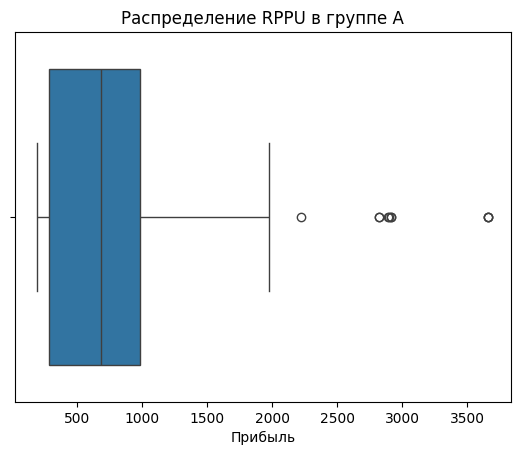

In [59]:
# Отображаем распределение RPPU в группе А в форме боксплота

sns.boxplot(data = a_group_rppu, x = 'rev')
plt.title("Распределение RPPU в группе A")
plt.xlabel('Прибыль')

Text(0.5, 0, 'Прибыль')

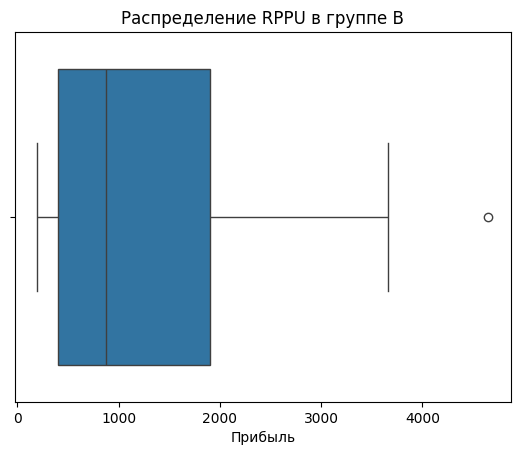

In [60]:
# Отображаем распределение RPPU в группе B в форме боксплота

sns.boxplot(data = b_group_rppu, x = 'rev')
plt.title("Распределение RPPU в группе B")
plt.xlabel('Прибыль')

По боксплотам видно, что в обеих группах есть выбросы, причем в разном количестве: примерно 4 в группе А против одного в группе B. Кроме того видно, что в боксплотах разная ширина IQR и "усов". Это может указывать на разность дисперсий в группах.

#### Проверяем равенство дисперсий

In [61]:
# Проверяем равенство дисперсий с помощью теста Левена
levene_res_arppu = st.levene(a_group_rppu['rev'], b_group_rppu['rev'])

print(levene_res_arppu)

LeveneResult(statistic=np.float64(4.099799827819424), pvalue=np.float64(0.043381693677143875))


Тест Левена показывает p-value ~= 0.04, что ниже порога значимости в 0.05 <br>
Требование к равенству дисперсий RPPU в группах не соблюдается

**Вывод по стат критерию для ARPPU:** <br>
Для ARPPU Т-тест также не подойдет: не соблюдаются требования к нормальности распределений и равенству дисперсий, а также наблюдаются выбросы. Для ARPPU также будем использовать Бутстрап с 95% ДИ. <br>

## Проводим расчет тестов



### Сравниваем ARPU в группах с помощью Bootstrap

In [62]:
# Оцениваем ARPU на основе бутстрапированной выборки в группе A
# Из-за большого размера выборки в группе B придется немного изменить стандартные аргументы функции bootstrap:
# method -- 'basic' вместо 'BCa'. Стандартный 'BCa' использует слишком много памяти
# n_resamples -- снизить со стандартных 9999 до 8000, опять же для экономии ресурсов

arpu_bootstrap_res_a = st.bootstrap((a_group_rpu['rev'],), 
                                    statistic = np.mean, 
                                    method = 'basic', # меняем метод на 'basic'
                                    n_resamples = 8000) # 8000 resamples вместо 9999

In [63]:
# Оцениваем ARPU на основе бутстрапированной выборки в группе B

arpu_bootstrap_res_b = st.bootstrap((b_group_rpu['rev'],), 
                                    statistic = np.mean, 
                                    method = 'basic', # меняем метод на 'basic'
                                    n_resamples = 8000) # 8000 resamples вместо 9999

In [64]:
print (f'Доверительный интервал ARPU в группе A: {arpu_bootstrap_res_a.confidence_interval}')
print (f'Доверительный интервал ARPU в группе B: {arpu_bootstrap_res_b.confidence_interval}')

Доверительный интервал ARPU в группе A: ConfidenceInterval(low=np.float64(4.558019221593621), high=np.float64(7.8270789312248645))
Доверительный интервал ARPU в группе B: ConfidenceInterval(low=np.float64(7.084729140989415), high=np.float64(8.90161343186264))


**Вывод по различию ARPU:** <br>
Доверительные интервалы ARPU в группах A и B пересекаются. Различия не являются статистически значимыми

### Сравниваем ARPPU в группах с помощью Bootstrap

In [65]:
# Оцениваем ARPPU на основе бутстрапированной выборки в группе A

arppu_bootstrap_res_a = st.bootstrap((a_group_rppu['rev'],), statistic = np.mean)

In [66]:
# Оцениваем ARPPU на основе бутстрапированной выборки в группе B

arppu_bootstrap_res_b = st.bootstrap((b_group_rppu['rev'],), statistic = np.mean)

In [67]:
print (f'Доверительный интервал ARPPU в группе A: {arppu_bootstrap_res_a.confidence_interval}')
print (f'Доверительный интервал ARPPU в группе B: {arppu_bootstrap_res_b.confidence_interval}')

Доверительный интервал ARPPU в группе A: ConfidenceInterval(low=np.float64(726.6467223073914), high=np.float64(1035.0155548191617))
Доверительный интервал ARPPU в группе B: ConfidenceInterval(low=np.float64(1039.646503989906), high=np.float64(1177.455859779089))


**Вывод по различию ARPPU**:<br>
Доверительные интервалы ARPPU в группах не пересекаются. Различия статистически значимы.<br> 
Однако, так как за основную метрику мы берем именно ARPU, статзначимость различий ARPPU не играет решающей роли.

## Делаем вывод по итогам анализа A/B-теста

Из двух метрик статистически значимые различия видны только по одной -- ARPPU. Этого недостаточно, чтобы уверенно принять решение в пользу новой механики оплаты. Основных причин две:
1. Сама метрика ARPPU -- здесь скорее вспомогательная. Ключевое значение имеет ARPU. 
2. Доверительные интервалы ARPPU в двух группах хоть и не пересекаются, но находятся очень близко друг к другу. Лучше провести более детальный анализ, и если возможно, собрать больше данных.

**Итог:**<br>
Новую механику оплаты не раскатываем на всех пользователей.

# Решаем задачу 2

## Описываем подзадачи

### 1. Подсчет усердных учеников
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**Задача:** <br>
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

### 2. Расчет прибыли на пользователя и CR в покупку курсов

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

**Задача:** <br>
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

## Описываем входные данные
Эти таблицы лежат в БД Clickhouse. Чтобы получить их, будем подключаться к БД и считавать данные с помощью pandahouse

- Таблица '**default.peas**':



|**Название атрибута**|**Тип атрибута**|**Смысловое значение**|
|----------|---------|----------------------|
|st_id|int|ID ученика|
|timest|timestamp|Время решения карточки|
|correct|bool|Правильно ли решена горошина?|
|subject|text|Дисциплина, в которой находится горошина|

- Таблица '**default.studs**':

|Название атрибута|Тип атрибута|Смысловое значение|
|-----------------|------------|------------------|
|st_id|int|ID ученика|
|test_grp|text|Метка ученика в данном эксперименте|
  


- Таблица '**default.final_project_check**':

|Название атрибута|Тип атрибута|Смысловое значение|
|-----------------|------------|------------------|
|st_id|int|ID ученика|
|sale_time|timestamp|Время покупки|
|money|int|Цена, по которой приобрели данный курс|
|subject|text|Название дисциплины|

## Переходим к решению задач

### Подключаемся к базе данных Clickhouse

In [68]:
# Прописываем параметры подключения в словарь 

connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

### Решаем задачу 1. Подсчет усердных учеников
В этой задаче нам нужно подсчитать количество усердных учеников. Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 "горошин".

In [69]:
# Пишем SQL-запрос для получения данных из Clickhouse
# Данные будем получать из таблицы 'default.peas'

count_hardworking_students_query = """
SELECT
  COUNT (st_id) AS hardworking_students_count -- считаем кол-во студентов в таблице из позапроса
FROM
  (
    SELECT
      st_id,
      COUNT(st_id) AS peas_completed -- считаем кол-во выполненных горошин
    FROM
      default.peas
    WHERE
      correct = 1 -- осталвяем только корректно решенные горошины
    GROUP BY
      st_id -- группируем по студенту
    HAVING
      peas_completed >= 20 -- после аггрегации оставляем только студентов с 20+ решенных горошин
    ORDER BY
      peas_completed DESC
  )

"""

In [70]:
# Результат запроса записывается в dataframe размером 1x1
# Записываем этот df в переменную

count_hardworking_students_result = ph.read_clickhouse(count_hardworking_students_query, connection = connection_default)

In [71]:
# Выводим на печать значение в первой строке первого столбца 
print(f"Количество усердных студентов -- {count_hardworking_students_result.iloc[0,0]}") 

Количество усердных студентов -- 136


### Решаем задачу 2. Расчет прибыли на пользователя и CR в покупку курсов

В этой задаче нам нужно в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [72]:
# Пишем SQL-запрос для получения данных из Clickhouse
# Данные будем получать из таблиц 'default.peas', 'default.studs' и default.final_project_check

metrics_for_ab_groups_query = """
SELECT
  test_grp,
  avg(revenue) AS ARPU, -- усредняем прибыль и получаем ARPU
  avgIf(revenue, is_active = 1) AS ARPAU, -- усредняем прибыль активных пользователей и получаем ARPAU
  avg(is_paying) AS CR1, -- усредняем частоту платящих/не платящих студентов и получаем CR1
  avgIf(is_paying, is_active = 1) AS active_to_paying_CR, -- по аналогии с CR1 рассчитываем CR1 для активных студентов
  avgIf(is_paying_math, is_active_math = 1) AS math_active_to_paying_CR -- по той же логике - CR1 для активных по математике
FROM
  (
    SELECT
      studs.st_id AS st_id,
      studs.test_grp AS test_grp,
      revenue_by_stud.rev_any_subj AS revenue, -- считаем прибыль на пользователя для ARPU
      if(peas_completed.peas_completed > 10, 1, 0) AS is_active, -- промечаем активных пользователей
      if(peas_completed.math_peas_completed >= 2, 1, 0) AS is_active_math, -- промечаем активных пользователей по математике
      if(revenue_by_stud.rev_any_subj > 0, 1, 0) AS is_paying, -- промечаем платящих пользователей
      if(revenue_by_stud.rev_math > 0, 1, 0) AS is_paying_math -- промечаем платящих пользователей по математике
    FROM
      default.studs 
      LEFT JOIN ( -- джоиним данные по прибыли по пользователям, чтобы рассчитать ARPU и ARPAU и прометить платящих студентов
        SELECT
          st_id,
          sum(money) AS rev_any_subj, -- считаем прибыль по любым дисциплинам
          sumIf(money, subject = 'Math') as rev_math -- считаем прибыль по математике
        FROM
          default.final_project_check
        GROUP BY
          st_id
      ) AS revenue_by_stud ON default.studs.st_id = revenue_by_stud.st_id
      LEFT JOIN ( -- джоиним данные по кол-ву решенных горошен, чтобы прометить активных и неактивных студентов
        SELECT
          st_id,
          COUNT(st_id) peas_completed,-- считаем кол-во любых решенных горошен
          countIf(st_id, subject = 'Math') AS math_peas_completed -- считаем кол-во решенных горошен по математике
        FROM
          default.peas
        WHERE
          correct = 1 -- фильтруем, чтобы считать только решенные горошины
        GROUP BY
          st_id
        ORDER BY
          peas_completed ASC
      ) AS peas_completed ON default.studs.st_id = peas_completed.st_id
  ) AS pre_aggregated_data
GROUP BY
-- группируем по контрольной/пилотной группе
  test_grp 

"""

In [73]:
# Результат запроса записывается в dataframe
# Записываем этот df в переменную

metrics_for_ab_groups_result = ph.read_clickhouse(metrics_for_ab_groups_query, connection = connection_default)

In [74]:
# Выводим переменную на печать
metrics_for_ab_groups_result

,test_grp,ARPU,ARPAU,CR1,active_to_paying_CR,math_active_to_paying_CR
0,control,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.095238


# Решаем задачу 3
В этой задаче нужно реализовать 2 функции:
1. Функция, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Функция, которая будет строить графики по получаемым метрикам.

## Пишем функцию для рассчета метрик

In [75]:
def ab_metrics_joiner_calculator (existing_groups,new_groups,active_users,revenue_table):
    """
    Функция принимает на вход в качестве аргументов 4 Pandas DataFrame:
    1. existing_groups -- имеющийся df с группами пользователей. Должен быть в формате id | group
    2. new_groups -- новый df в таком же формате, как existing_groups
    3. active_users -- df c пользователями, которые считаются активными. Должен иметь 1 колонку с id юзеров
    4. revenue_table -- df с прибылью для каждого пользователя. Должен быть в формате id | revenue
    
    Данные из new_groups добавляются к existing_groups, и на основе полученной таблицы происходит перерасчет метрик.
    Какие метрики рассчитывает функция:
    ARPAU        -- Средний Доход на Активного Пользователя
    ARPAPU       -- Средний Доход на Активного Платящего Пользователя
    Paying Share -- Процент Платящих Пользователей
    
    Функция возвращает вложенные словари. В словарях для каждой метрики есть данные в пяти форматах:
    1. Неаггрегированная таблица для группы А - ключ 'a_group_source_table'
    2. Неаггрегированная таблица для группы B - ключ 'b_group_source_table'
    3. Неаггрегированная таблица для обеих групп - ключ 'ab_group_source_table'
    4. Значение метрики в группе А - ключ 'a_group_value'
    5. Значение метрики в группе B - ключ 'b_group_value'
    
    Обращаться к ключам нужно в формате ['метрика']['формат_данных']
    
    Пример использования:
    Вам нужно узнать значения ARPAU в группе A
    
    1. Выполните фукнцию и запишите результат в любую переменную, например, results
    results = ab_metrics_joiner_calculator(existing_groups,new_groups,active_users,revenue_table)
    2. Обратитесь к ключам в формате results['arpau']['a_group_value']
    
    """
    
    # Переименовываем колонки в таблицах на случай, если они будут названы иначе.
    # Таким образом исключаем возможность конфликтов при работе таблиц
    existing_groups = existing_groups.rename(columns = {existing_groups.columns[0]:'id', existing_groups.columns[1]:'grp'})
    new_groups = new_groups.rename(columns = {new_groups.columns[0]:'id', new_groups.columns[1]:'grp'})
    active_users = active_users.rename(columns = {active_users.columns[0]:'id'})
    revenue_table = revenue_table.rename(columns = {revenue_table.columns[0]:'id', revenue_table.columns[1]:'rev'})
    
    # Склеиваем новый и имеющийся dataframe через pd.concat
    united_groups = pd.concat([existing_groups, new_groups], axis = 0)
    
    # Делаем таблицу групп только с активными пользователями
    groups_w_active_users_only = united_groups[united_groups['id'].isin(active_users['id'])]
    
    # Делаем таблицу прибыли только с активными пользователями
    revenue_table_w_active_users_only = revenue_table[revenue_table['id'].isin(active_users['id'])]
    
    

    # Рассчитываем ARPAU
    # Джоиним прибыль пользователей из revenue_table_w_active_users_only в groups_w_active_users_only
    groups_w_rpau = (groups_w_active_users_only
                    .merge(right = revenue_table_w_active_users_only, how = 'left', on = 'id') # джоиним
                    .fillna(value = 0) # заполняем null-значения нулями
                    )
    
    # Разбиваем получившуюся таблицу c RPAU на две по группам A и B
    a_group_rpau_table = groups_w_rpau.query('grp == "A"')
    b_group_rpau_table = groups_w_rpau.query('grp == "B"')
    
    # Рассчитываем ARPAU в каждой группе, вычислив среднее значение
    a_group_arpau = a_group_rpau_table['rev'].mean()
    b_group_arpau = b_group_rpau_table['rev'].mean()
    

    
    # Рассчитываем ARPAPU
    # Джоиним группы пользователей из groups_w_active_users_only в revenue_table_w_active_users_only
    groups_w_rpapu = revenue_table_w_active_users_only.merge(right = groups_w_active_users_only, how = 'left', on = 'id')
    
    # Разбиваем получившуюся таблицу с RPAPU на две по группам A и B
    a_group_rpapu_table = groups_w_rpapu.query('grp == "A"')
    b_group_rpapu_table = groups_w_rpapu.query('grp == "B"')
    
    # Рассчитываем ARPAPU в каждой группе, вычислив среднее значение
    a_group_arpapu = a_group_rpapu_table['rev'].mean()
    b_group_arpapu = b_group_rpapu_table['rev'].mean()
    
    
    
    # Рассчитываем Paying Share
    # Создаем в таблице groups_w_rpau колонку is_paying, которая указывает, платящий пользователь или нет
    # Значение в ней будет:
    # 0, если прибыль ('rev') = 0  
    # 1, если прибыль ('rev') > 0 
    
    groups_w_rpau['is_paying'] = (groups_w_rpau['rev']
                                  .apply(lambda x: 0 if x == 0 else 1))
    
    
    # Делим таблицу 'groups_filtered_w_rev' на две по группам A и B
    a_group_is_paying_table = groups_w_rpau.query('grp == "A"')
    b_group_is_paying_table = groups_w_rpau.query('grp == "B"')
    
    # Вычисляем долю платящих пользователей (Paying Share) в каждой группе.
    # Для этого вычисляем среднее значение по колонке 'is_paying' и умножаем на 100%
    a_group_paying_share = round(a_group_is_paying_table['is_paying'].mean() * 100, 2) # вычисляем и округляем до 2 знаков
    b_group_paying_share = round(b_group_is_paying_table['is_paying'].mean() * 100, 2) # после запятой
    

    # Возвращаем результаты всех вычислений в виде вложенного словаря, чтобы иметь возможность обращаться к ним далее
    
    return {
        'arpau':{ # данные по ARPAU
            'a_group_source_table':a_group_rpau_table, # группа А, таблица без аггрегации
            'b_group_source_table':b_group_rpau_table, # группа B, таблица без аггрегации
            'ab_groups_source_table':groups_w_rpau, # Обе группы, таблица без аггрегации
            'a_group_value':a_group_arpau, # группа А, значение метрики
            'b_group_value':b_group_arpau  # группа B, значение метрики
        },
        'arpapu':{ # данные по ARPAPU
            'a_group_source_table':a_group_rpapu_table, # группа А, таблица без аггрегации
            'b_group_source_table':b_group_rpapu_table, # группа B, таблица без аггрегации
            'ab_groups_source_table':groups_w_rpapu, # Обе группы, таблица без аггрегации
            'a_group_value':a_group_arpapu, # группа А, значение метрики
            'b_group_value':b_group_arpapu  # группа B, значение метрики      
        },
        'paying_share':{ # данные по Paying Share
            'a_group_source_table':a_group_is_paying_table, # группа А, таблица без аггрегации
            'b_group_source_table':b_group_is_paying_table, # группа B, таблица без аггрегации
            'ab_groups_source_table':groups_w_rpau, # Обе группы, таблица без аггрегации
            'a_group_value':a_group_paying_share, # группа А, значение метрики
            'b_group_value':a_group_paying_share  # группа B, значение метрики
        }
    }
    

### Демонстрируем работу функции для рассчета метрик

In [76]:
# Записываем результаты функции
results = ab_metrics_joiner_calculator(groups, groups_add,active_studs,checks)

In [77]:
# Из словаря с результатами выбираем таблицу с данными для метрики ARPAPU
test_source_table_arpapu = results['arpapu']['ab_groups_source_table']

In [78]:
# Выводим на печать таблицу с данными для ARPAPU 
print(test_source_table_arpapu)

          id        rev grp
0       1627   990.0000   A
1     100300   990.0000   B
2     108270   290.0000   B
3     264473  1900.0001   B
4     274352   690.0000   B
..       ...        ...  ..
387  5645737  1900.0000   B
388  5651566  1900.0000   B
389  5662322  1900.0000   B
390  5681918  1900.0000   B
391  5740903  1900.0000   B

[392 rows x 3 columns]


In [79]:
# Теперь выбираем из словаря значение метрики ARPAPU в группе А
test_metric_value_arpapu = results['arpapu']['a_group_value']

In [80]:

# Выводим на печать получившееся значение метрики ARPAPU в группе А
print(test_metric_value_arpapu)

933.5897435897435


## Пишем функцию для отрисовки графиков на основе вычисленных метрик

In [81]:
def chart_plotter(data, result, values_column, group_column=None, metric_name=None):
    
    """
    Эта функция отрисовывает графики метрик. Графики отрисовываются в двух видах на выбор:
    - значение метрики
    - распределение метрики
    
    Функция принимает на вход 3 обязательных и 2 опциональных аргумента:
    
    1. data -- Pandas DataFrame
    DataFrame с данными
    
    2. result -- string
    Данные в каком формате нужно отрисовать. 
    При значении 'metric' отрисуется значение метрики, например, ARPU.
    При значении 'distribution' отрисуется распределение метрики. В случае ARPU -- это распределение revenue per user
    
    3. values_column -- string
    Rолонка с значениями для рассчета метрики и отрисовки графиков
    
    4. group_column -- string -- опционально 
    Колонка с значениями групп, например, A и B. Если не указать, графики будут строиться без разбивки по группам
    
    5. metric_name -- string -- опционально 
    Название отображаемой метрики. Используется для подписи тайтла и осей на графике.
    Если не указать, в подпися оси будет просто "метрика", например, "Значения метрики в группах А и Б"
                                       
    """
    
    # Первый сценарий: если выбрана отрисовка значений метрики
    if result == 'metric':
        if group_column: # если указана колонка с группой, то считаем метрики с разбивкой по группе
            
            # Вычисляем среднее значение метрики по группам
            mean_by_group = (data
                             .groupby(group_column, as_index = False) # группируем по колонке с группой
                             .agg({values_column:'mean'}) # считаем среднее
                             .rename(columns = {group_column:'group', values_column:'metric_value'})
                            ) # меняем именя колонок, чтобы не путать их с исходными колонками
            
            plt.figure(figsize=(7, 4.9)) # Задаем размер полотна больше стандартного для лучшего восприятия
            sns.barplot(data = mean_by_group, # рисуем барплот с разбивкой по группам
                        x = 'group', 
                        y = 'metric_value') 
            if metric_name: # Если в аргументах указано название метрики (metric_name), используем в его подписях
                plt.title(f"Значение {metric_name} в группах A и B") # Подписываем тайтл со именем метрики
                plt.xlabel("Группа") # подписываем ось X
                plt.ylabel(f'{metric_name}') # подписываем ось Y с именем метрики
            else: # Если в аргументах не указано metric_name, то также подписываем тайтл и оси, но без имени метрики
                plt.title("Значение метрики в группах А и B")  
                plt.xlabel("Группа")
                plt.ylabel('Значение метрики')

        else: # если колонка с группой не указана, то метрику рассчитываем по всему набору данных без разбивки
            mean_wo_grouping = (data
                               .agg({values_column:'mean'}) # считаем среднее
                               )
            sns.barplot(data = mean_wo_grouping) # Рисуем барплот
            if metric_name: # Если в аргументах указано metric_name, используем его в подписях тайтла и осей
                plt.title(f"Значение {metric_name} без разбивки по группам")
                plt.xlabel("Все данные")
                plt.ylabel(f'{metric_name}')
            else: # Если metric_name не указано, подписываем тайтл и оси без него
                plt.title("Значение метрики без разбивки по группам")
                plt.xlabel("Все данные")
                plt.ylabel('Значение метрики')

        
        
    # Второй сценарий: если выбрана отрисовка распределения метрики   
    elif result == 'distribution':
        if data[values_column].nunique() > 2: # Проверяем, не является ли переменная метрики бинарной (категориальной)  
            if group_column: # если указана колонка с группой, то рисуем распределение с разбивкой по группе
                plt.figure(figsize=(10, 4.9)) # задаем размер полотна больше стандартного, чтобы лучше видеть график
                sns.histplot(data = data, # строим гистограмму
                            x = values_column, # по оси x откладываем значения переменной нашей метрики
                            hue = group_column, # делаем цветовую разбивку по колонке группы
                            bins = 15, # настраеваем кол-во бинов
                            alpha = 0.8, # делаем небольшую прозрачность, чтобы лучше различать значения 
                            palette=["#FF9F45", "#5C5E8E"]) # выбираем подходящую палитру
                
                if metric_name: # Если в аргументах указано (metric_name), используем в его подписях тайтла и оси
                    plt.title(f"Распределение {metric_name} в группах A и B")
                    plt.xlabel(f'Значение {metric_name}')
                    plt.ylabel('Кол-во наблюдений')
                else: # Если metric_name не указано, подписываем тайтл и оси без него
                    plt.title("Распределение метрики в группах A и B")
                    plt.xlabel("Значение метрики")
                    plt.ylabel('Кол-во наблюдений')
            else: # Если колонка с группой не указана, то рисуем распределение без разбивки на группы
                plt.figure(figsize=(10, 4.9)) # задаем размер полотна больше стандартного, чтобы лучше видеть график
                sns.histplot(data = data, # рисуем гистограмму 
                            x = values_column, # по оси x откладываем значения переменной нашей метрики
                            bins = 15, # настраиваем кол-во бинов 
                            alpha = 0.8) # делаем небольшую прозрачность, чтобы лучше различать значения
                
                if metric_name: # Если в аргументах указано metric_name, используем его в подписях тайтла и осей
                    plt.title(f"Распределение {metric_name} без разбивки по группам")
                    plt.xlabel(f"Значение {metric_name}")
                    plt.ylabel('Кол-во наблюдений')
                else: # Если metric_name не указано, подписываем тайтл и оси без него
                    plt.title("Распределение метрики без разбивки по группам")
                    plt.xlabel("Значение метрики")
                    plt.ylabel('Кол-во наблюдений')
        
        elif data[values_column].nunique() == 2: # Если кол-во значений переменной = 2, то она категориальная и бинарная
                                                 # В таком случае график нужно будет строить иначе
            if group_column: # если указана колонка с группой, то считаем метрики с разбивкой по группе
                plt.figure(figsize=(7, 4.9)) # Задаем размер полотна больше стандартного, чтобы лучше видеть график
                sns.histplot(data = data, 
                             x = group_column, # по оси X откладываем группы
                             hue = values_column, # делаем цветовую разбивку по значению метрики (например, 0 / 1)
                             bins = 15, # настраиваем кол-во бинов
                             alpha = 0.8, # делаем небольшую прозрачность, чтобы лучше различать значения
                             palette=["#FF9F45", "#5C5E8E"], # настраиваем подходящую палитру 
                             discrete =  True, # Указываем, что значения дискретные, чтобы избежать зазоры между столбцами 
                             stat = 'probability', # Выбираем отрисовывать процентное соотношение, а не кол-во
                             common_norm = True, # Выбираем нормализацию обоих столбцов по общей шкале
                             multiple = 'fill',  # Делаем, чтобы столбец занимал всю высоту и отражал соотношение
                             shrink = 0.5) # обрезаем столбцы по бокам
                
                if metric_name: # Если в аргументах указано metric_name, используем его в подписях тайтла и осей
                    plt.title(f"Распределение {metric_name} в группах A и B")
                    plt.xlabel("Все данные")
                    plt.ylabel(f'Значение {metric_name}')
                else: # Если metric_name не указано, подписываем тайтл и оси без него
                    plt.title("Распределение метрики в группах A и B")
                    plt.xlabel("Все данные")
                    plt.ylabel('Значение метрики')
                    
            else: # Если колонка с группой не указана, то рисуем распределение без разбивки на группы
                
                # Вычисляем соотношение категорий метрики. В случае Paying Share -- соотношение 0 и 1
                binary_dist_wo_groups = (data[values_column] 
                                        .value_counts(normalize = True) # считаем соотношение
                                        .reset_index() # сбрасываем индекс, чтобы иметь колонку для оси X
                                        .rename(columns = {'index':'category', values_column:'category_value'}) 
                                        ) # переименовываем колонки, чтобы не путать с исходными
                
                plt.figure(figsize=(7, 4.9)) # Задаем размер полотна больше стандартного, чтобы лучше видеть график
                sns.barplot(data = binary_dist_wo_groups, # рисуем барплот по полученной таблице
                           x = 'category', # по оси X отклыдваем категории переменной (0 и 1)
                           y = 'category_value' # по оси Y откладываем процент этой категори от общего числа
                           )
                
                # Подписываем тайтл и оси графика постоянными значениями, т.к. заранее знаем, что будет на графике
                plt.title("Соотношение платящих и неплатящих в группах A и B")
                plt.xlabel("Платящие и неплатящие пользователи")
                plt.ylabel('Процент')       
                    


### Демонстрируем работу функции для отрисовки графиков

In [82]:
# Получаем таблицу с данными для метрики ARPAU из словаря results, 
# который сделали ранее с помощью функции расчета метрик

both_groups_arpau_data = results['arpau']['ab_groups_source_table']

# Проверяем, что таблица создалась корректно
both_groups_arpau_data.head()

,id,grp,rev,is_paying
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


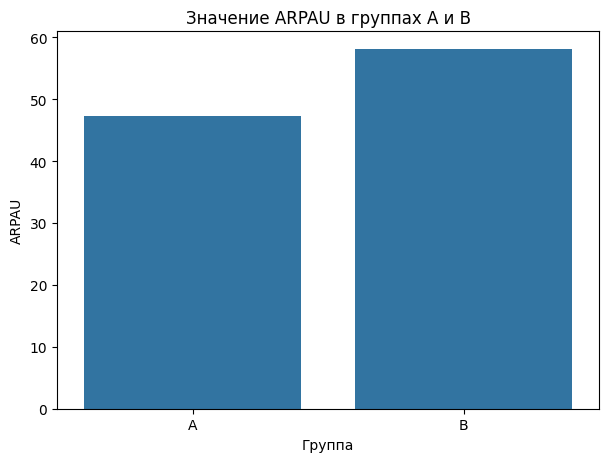

In [83]:
# Делаем график для значения метрики ARPAU с разбивкой по группам
chart_plotter(both_groups_arpau_data, 'metric', 'rev', group_column='grp', metric_name= 'ARPAU')

In [87]:
# Теперь отрисуем распределение метрики ARPAPU
# Получаем таблицу с данными для метрики ARPAPU из заранее созданного словаря results

both_groups_arpapu_data = results['arpapu']['ab_groups_source_table']

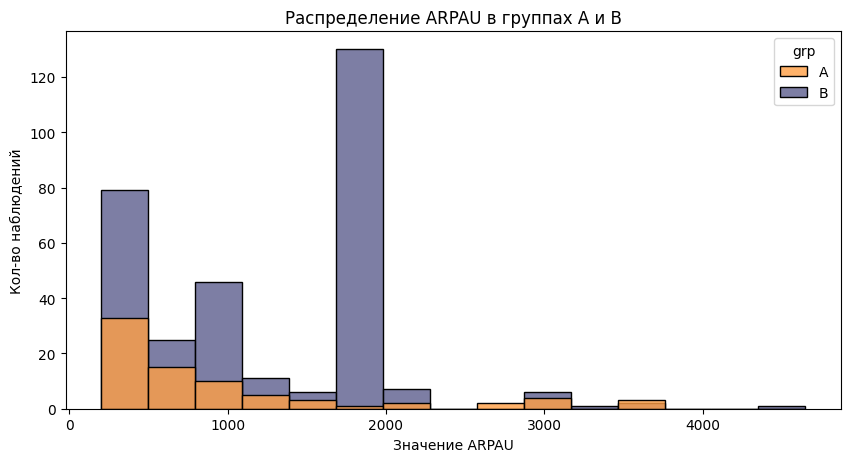

In [88]:
# Делаем график для распределения метрик ARPAPU с разбивкой по группам
chart_plotter(both_groups_arpapu_data, 'distribution', 'rev', group_column='grp', metric_name= 'ARPAU')
